In [1]:
import sys
sys.path.insert(0,"../Code/Classes")
from DataClass import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def split_image(img,n_splits):
    #Assuming squares
    sz_xy = img.shape[0]
    sz_sm = int(sz_xy/n_splits)
    lay = img.shape[2]
    out = np.zeros((n_splits**2,sz_sm,sz_sm,lay))
    for i in range(n_splits):
        for j in range(n_splits):
            c_x = sz_sm*i
            c_y = sz_sm*j
            out[n_splits*i+j,:,:,:] = img[c_x:c_x+sz_sm,c_y:c_y+sz_sm,:]
    return out            

In [3]:
def unsplit_image(imgs):
    num_splits = imgs.shape[0]
    s_splits = int(np.sqrt(num_splits))
    sm_res = imgs.shape[1]
    channels = imgs.shape[3]
    
    big_res = sm_res*s_splits
    
    out = np.zeros((big_res,big_res,channels))
    for i in range(s_splits):
        for j in range(s_splits):
            c_x = sm_res*i
            c_y = sm_res*j
            out[c_x:c_x+sm_res,c_y:c_y+sm_res,:]=imgs[s_splits*i+j,:,:,:]
    return out            

In [5]:
dataloader = DataLoader()
dataloader.load_std_folder("../../Data/STD_Folder")
dataloader.parse_biclass()

In [6]:
size_f = 1080
size_r = 27
#Assuming square
splits = int(size_f/size_r)

In [7]:
full_num_img = len(dataloader.classfiles)
im_indices = [a for a in range(full_num_img)]

In [12]:
#84092
from sklearn.model_selection import train_test_split
import cv2

samp_per_img = 256

split_range = [a for a in range(splits*splits)]
samp = train_test_split(split_range,train_size = samp_per_img)[0]

X = np.zeros((full_num_img*samp_per_img,size_r,size_r,1))
y = np.zeros((full_num_img*samp_per_img,size_r,size_r),bool)
for a in im_indices:
    c_ind = a*samp_per_img
    tmp = dataloader.get_data("depth",[a])[0]
    tmp = np.moveaxis([tmp],(0,1,2),(2,0,1))
    c_img = split_image(tmp,splits)
    c_class_tmp = dataloader.get_data("class",[a])[0]
    c_class = split_image(cv2.resize(c_class_tmp,(1080,1080)),splits)[:,:,:,0].astype(bool)
    X[c_ind:c_ind+samp_per_img,:,:,:] = c_img[samp]
    y[c_ind:c_ind+samp_per_img,:,:] = c_class[samp]
y = np.moveaxis(np.asarray([y],bool),(0,1,2,3),(3,0,1,2))

X = np.asarray([(a-np.min(a,0))/(np.max(a)-np.min(a)) for a in X])

#261096k

In [13]:
np.sum(y)/y.size

0.5253039754475526

In [14]:
test_size = 0.1
val_size = 0.1

shape_range = [a for a in range(X.shape[0])]

t_ind,test_inmind = train_test_split(shape_range,test_size=test_size)
train_ind,val_ind = train_test_split(t_ind,test_size=val_size)

X_train,y_train = X[train_ind],y[train_ind]
X_val,y_val = X[val_ind],y[val_ind]
X_test,y_test = X[test_ind],y[test_ind]

In [44]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=7,input_shape = [size_r,size_r,1],
                              activation="tanh", padding="same"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
model.add(keras.layers.MaxPool2D(2, padding="same"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
model.add(keras.layers.MaxPool2D(2, padding="same"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
model.add(keras.layers.Conv2D(filters=2,kernel_size=3,activation="relu", padding="same"))

#model.add(keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"))
#model.add(keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
model.add(keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
model.add(keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"))
model.add(keras.layers.Conv2D(filters=32,kernel_size=2,activation="relu"))
model.add(keras.layers.Conv2D(1,kernel_size=3,activation="sigmoid", padding="same"))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 27, 27, 32)        1600      
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 7, 7, 2)         

In [45]:
model.compile(loss="mean_squared_error",metrics = [keras.metrics.RootMeanSquaredError()],
             optimizer="nadam")

In [56]:
history = model.fit(X_train,X_train,epochs=3600,validation_data=(X_val,X_val),batch_size=32)

Epoch 1/3600
512/512 [==============================] - 5s 10ms/step - loss: 4.3249e-04 - root_mean_squared_error: 0.0208 - val_loss: 4.2927e-04 - val_root_mean_squared_error: 0.0207
Epoch 2/3600
512/512 [==============================] - 5s 10ms/step - loss: 4.1328e-04 - root_mean_squared_error: 0.0203 - val_loss: 3.8268e-04 - val_root_mean_squared_error: 0.0196
Epoch 3/3600
512/512 [==============================] - 5s 10ms/step - loss: 4.1816e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.9523e-04 - val_root_mean_squared_error: 0.0199
Epoch 4/3600
512/512 [==============================] - 5s 10ms/step - loss: 4.4514e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.8512e-04 - val_root_mean_squared_error: 0.0196
Epoch 5/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.8248e-04 - root_mean_squared_error: 0.0196 - val_loss: 4.2622e-04 - val_root_mean_squared_error: 0.0206
Epoch 6/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.9822e-

Epoch 90/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.2507e-04 - root_mean_squared_error: 0.0180 - val_loss: 4.6697e-04 - val_root_mean_squared_error: 0.0216
Epoch 91/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.3245e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.4874e-04 - val_root_mean_squared_error: 0.0187
Epoch 92/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.2598e-04 - root_mean_squared_error: 0.0181 - val_loss: 4.4230e-04 - val_root_mean_squared_error: 0.0210
Epoch 93/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.3231e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.4691e-04 - val_root_mean_squared_error: 0.0186
Epoch 94/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.2239e-04 - root_mean_squared_error: 0.0180 - val_loss: 3.4382e-04 - val_root_mean_squared_error: 0.0185
Epoch 95/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.2

512/512 [==============================] - 5s 10ms/step - loss: 3.4120e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.5069e-04 - val_root_mean_squared_error: 0.0187
Epoch 179/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.9686e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.0980e-04 - val_root_mean_squared_error: 0.0202
Epoch 180/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.0873e-04 - root_mean_squared_error: 0.0176 - val_loss: 3.3944e-04 - val_root_mean_squared_error: 0.0184
Epoch 181/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0360e-04 - root_mean_squared_error: 0.0174 - val_loss: 3.3914e-04 - val_root_mean_squared_error: 0.0184
Epoch 182/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0876e-04 - root_mean_squared_error: 0.0176 - val_loss: 3.7012e-04 - val_root_mean_squared_error: 0.0192
Epoch 183/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0665e-04 - ro

512/512 [==============================] - 5s 10ms/step - loss: 3.0086e-04 - root_mean_squared_error: 0.0173 - val_loss: 3.4593e-04 - val_root_mean_squared_error: 0.0186
Epoch 267/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.3967e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.4057e-04 - val_root_mean_squared_error: 0.0185
Epoch 268/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8793e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.4270e-04 - val_root_mean_squared_error: 0.0185
Epoch 269/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9740e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.6106e-04 - val_root_mean_squared_error: 0.0190
Epoch 270/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.9740e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.4148e-04 - val_root_mean_squared_error: 0.0185
Epoch 271/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9871e-04 - 

512/512 [==============================] - 5s 9ms/step - loss: 2.9439e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.7062e-04 - val_root_mean_squared_error: 0.0193
Epoch 355/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9287e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.4265e-04 - val_root_mean_squared_error: 0.0185
Epoch 356/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.3265e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.4338e-04 - val_root_mean_squared_error: 0.0185
Epoch 357/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9168e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.4301e-04 - val_root_mean_squared_error: 0.0185
Epoch 358/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9512e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.4331e-04 - val_root_mean_squared_error: 0.0185
Epoch 359/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9622e-04 -

512/512 [==============================] - 5s 10ms/step - loss: 2.8877e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.5754e-04 - val_root_mean_squared_error: 0.0189
Epoch 443/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8766e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.4961e-04 - val_root_mean_squared_error: 0.0187
Epoch 444/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9143e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.5263e-04 - val_root_mean_squared_error: 0.0188
Epoch 445/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8533e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4705e-04 - val_root_mean_squared_error: 0.0186
Epoch 446/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8754e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.4397e-04 - val_root_mean_squared_error: 0.0185
Epoch 447/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9053e-04 -

512/512 [==============================] - 5s 9ms/step - loss: 3.3234e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.4458e-04 - val_root_mean_squared_error: 0.0186
Epoch 531/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7804e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.4452e-04 - val_root_mean_squared_error: 0.0186
Epoch 532/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8296e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.5289e-04 - val_root_mean_squared_error: 0.0188
Epoch 533/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8434e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4802e-04 - val_root_mean_squared_error: 0.0187
Epoch 534/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8396e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.5188e-04 - val_root_mean_squared_error: 0.0188
Epoch 535/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8606e-04 - r

512/512 [==============================] - 5s 10ms/step - loss: 2.8724e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.6002e-04 - val_root_mean_squared_error: 0.0190
Epoch 619/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.9642e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.5412e-04 - val_root_mean_squared_error: 0.0188
Epoch 620/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8640e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4896e-04 - val_root_mean_squared_error: 0.0187
Epoch 621/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8422e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4638e-04 - val_root_mean_squared_error: 0.0186
Epoch 622/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8281e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.6626e-04 - val_root_mean_squared_error: 0.0191
Epoch 623/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8266e-04 - roo

512/512 [==============================] - 5s 10ms/step - loss: 2.8231e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.7993e-04 - val_root_mean_squared_error: 0.0195
Epoch 707/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8448e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4776e-04 - val_root_mean_squared_error: 0.0186
Epoch 708/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7903e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.7389e-04 - val_root_mean_squared_error: 0.0193
Epoch 709/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0469e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.4846e-04 - val_root_mean_squared_error: 0.0187
Epoch 710/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7005e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.4723e-04 - val_root_mean_squared_error: 0.0186
Epoch 711/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8037e-04 -

512/512 [==============================] - 5s 10ms/step - loss: 2.7941e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5862e-04 - val_root_mean_squared_error: 0.0189
Epoch 795/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8023e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.6015e-04 - val_root_mean_squared_error: 0.0190
Epoch 796/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.1944e-04 - root_mean_squared_error: 0.0179 - val_loss: 3.7799e-04 - val_root_mean_squared_error: 0.0194
Epoch 797/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7243e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5131e-04 - val_root_mean_squared_error: 0.0187
Epoch 798/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7486e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.9248e-04 - val_root_mean_squared_error: 0.0198
Epoch 799/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7993e-04 -

512/512 [==============================] - 5s 9ms/step - loss: 3.1491e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.4964e-04 - val_root_mean_squared_error: 0.0187
Epoch 883/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6890e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.4923e-04 - val_root_mean_squared_error: 0.0187
Epoch 884/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7628e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.4820e-04 - val_root_mean_squared_error: 0.0187
Epoch 885/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7680e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5045e-04 - val_root_mean_squared_error: 0.0187
Epoch 886/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7787e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5755e-04 - val_root_mean_squared_error: 0.0189
Epoch 887/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7839e-04 - r

512/512 [==============================] - 5s 9ms/step - loss: 2.7495e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.4958e-04 - val_root_mean_squared_error: 0.0187
Epoch 971/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8741e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.7753e-04 - val_root_mean_squared_error: 0.0194
Epoch 972/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8481e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.6476e-04 - val_root_mean_squared_error: 0.0191
Epoch 973/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8694e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4718e-04 - val_root_mean_squared_error: 0.0186
Epoch 974/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8642e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.5035e-04 - val_root_mean_squared_error: 0.0187
Epoch 975/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.3264e-04 -

512/512 [==============================] - 5s 10ms/step - loss: 2.8827e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.6486e-04 - val_root_mean_squared_error: 0.0191
Epoch 1059/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8627e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.4931e-04 - val_root_mean_squared_error: 0.0187
Epoch 1060/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7617e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5330e-04 - val_root_mean_squared_error: 0.0188
Epoch 1061/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7710e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5234e-04 - val_root_mean_squared_error: 0.0188
Epoch 1062/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7875e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.4982e-04 - val_root_mean_squared_error: 0.0187
Epoch 1063/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7240

512/512 [==============================] - 5s 10ms/step - loss: 2.8498e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.5542e-04 - val_root_mean_squared_error: 0.0189
Epoch 1147/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7853e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5617e-04 - val_root_mean_squared_error: 0.0189
Epoch 1148/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8554e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.5160e-04 - val_root_mean_squared_error: 0.0188
Epoch 1149/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8333e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.5507e-04 - val_root_mean_squared_error: 0.0188
Epoch 1150/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7989e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5755e-04 - val_root_mean_squared_error: 0.0189
Epoch 1151/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7677e

512/512 [==============================] - 5s 10ms/step - loss: 2.7779e-04 - root_mean_squared_error: 0.0167 - val_loss: 4.4971e-04 - val_root_mean_squared_error: 0.0212
Epoch 1235/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7465e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.7802e-04 - val_root_mean_squared_error: 0.0194
Epoch 1236/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7497e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5603e-04 - val_root_mean_squared_error: 0.0189
Epoch 1237/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7814e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5540e-04 - val_root_mean_squared_error: 0.0189
Epoch 1238/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7587e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5096e-04 - val_root_mean_squared_error: 0.0187
Epoch 1239/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7445e-

512/512 [==============================] - 5s 10ms/step - loss: 2.7327e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5240e-04 - val_root_mean_squared_error: 0.0188
Epoch 1323/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7784e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.8599e-04 - val_root_mean_squared_error: 0.0196
Epoch 1324/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7868e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5149e-04 - val_root_mean_squared_error: 0.0187
Epoch 1325/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7849e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5308e-04 - val_root_mean_squared_error: 0.0188
Epoch 1326/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7320e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5398e-04 - val_root_mean_squared_error: 0.0188
Epoch 1327/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7544e-0

512/512 [==============================] - 5s 9ms/step - loss: 2.7658e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.6582e-04 - val_root_mean_squared_error: 0.0191
Epoch 1411/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7833e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5451e-04 - val_root_mean_squared_error: 0.0188
Epoch 1412/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8062e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.5366e-04 - val_root_mean_squared_error: 0.0188
Epoch 1413/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8069e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.5391e-04 - val_root_mean_squared_error: 0.0188
Epoch 1414/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7873e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5332e-04 - val_root_mean_squared_error: 0.0188
Epoch 1415/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.8093e-04 

512/512 [==============================] - 5s 9ms/step - loss: 2.7408e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5436e-04 - val_root_mean_squared_error: 0.0188
Epoch 1499/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7376e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5842e-04 - val_root_mean_squared_error: 0.0189
Epoch 1500/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7578e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.9774e-04 - val_root_mean_squared_error: 0.0199
Epoch 1501/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7478e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5816e-04 - val_root_mean_squared_error: 0.0189
Epoch 1502/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7421e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.7307e-04 - val_root_mean_squared_error: 0.0193
Epoch 1503/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7841e-04

512/512 [==============================] - 5s 9ms/step - loss: 2.7361e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5494e-04 - val_root_mean_squared_error: 0.0188
Epoch 1587/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7390e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5924e-04 - val_root_mean_squared_error: 0.0190
Epoch 1588/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7589e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.6267e-04 - val_root_mean_squared_error: 0.0190
Epoch 1589/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7440e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.5970e-04 - val_root_mean_squared_error: 0.0257
Epoch 1590/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0838e-04 - root_mean_squared_error: 0.0176 - val_loss: 3.5311e-04 - val_root_mean_squared_error: 0.0188
Epoch 1591/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6763e-04 

512/512 [==============================] - 5s 9ms/step - loss: 2.7129e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5468e-04 - val_root_mean_squared_error: 0.0188
Epoch 1675/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7325e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.8861e-04 - val_root_mean_squared_error: 0.0197
Epoch 1676/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7281e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6122e-04 - val_root_mean_squared_error: 0.0190
Epoch 1677/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7487e-04 - root_mean_squared_error: 0.0166 - val_loss: 4.0324e-04 - val_root_mean_squared_error: 0.0201
Epoch 1678/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7771e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.5978e-04 - val_root_mean_squared_error: 0.0190
Epoch 1679/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8331e-

512/512 [==============================] - 5s 9ms/step - loss: 2.7082e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5431e-04 - val_root_mean_squared_error: 0.0188
Epoch 1763/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7155e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5613e-04 - val_root_mean_squared_error: 0.0189
Epoch 1764/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7197e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5404e-04 - val_root_mean_squared_error: 0.0188
Epoch 1765/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7243e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5272e-04 - val_root_mean_squared_error: 0.0188
Epoch 1766/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7400e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5810e-04 - val_root_mean_squared_error: 0.0189
Epoch 1767/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7250e-0

512/512 [==============================] - 5s 9ms/step - loss: 2.6573e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.7470e-04 - val_root_mean_squared_error: 0.0194
Epoch 1851/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7149e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6145e-04 - val_root_mean_squared_error: 0.0190
Epoch 1852/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7342e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5516e-04 - val_root_mean_squared_error: 0.0188
Epoch 1853/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7184e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6075e-04 - val_root_mean_squared_error: 0.0190
Epoch 1854/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7315e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5400e-04 - val_root_mean_squared_error: 0.0188
Epoch 1855/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7108e-04 

512/512 [==============================] - 5s 9ms/step - loss: 2.9368e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.5403e-04 - val_root_mean_squared_error: 0.0188
Epoch 1939/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6731e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.7959e-04 - val_root_mean_squared_error: 0.0195
Epoch 1940/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7127e-04 - root_mean_squared_error: 0.0165 - val_loss: 4.1192e-04 - val_root_mean_squared_error: 0.0203
Epoch 1941/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7134e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7097e-04 - val_root_mean_squared_error: 0.0193
Epoch 1942/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7188e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5459e-04 - val_root_mean_squared_error: 0.0188
Epoch 1943/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7169e-04

512/512 [==============================] - 5s 9ms/step - loss: 2.7887e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.9842e-04 - val_root_mean_squared_error: 0.0200
Epoch 2027/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7410e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5370e-04 - val_root_mean_squared_error: 0.0188
Epoch 2028/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7024e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5503e-04 - val_root_mean_squared_error: 0.0188
Epoch 2029/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7299e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.8152e-04 - val_root_mean_squared_error: 0.0195
Epoch 2030/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.1470e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.5305e-04 - val_root_mean_squared_error: 0.0188
Epoch 2031/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6371e

512/512 [==============================] - 5s 10ms/step - loss: 2.7167e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5632e-04 - val_root_mean_squared_error: 0.0189
Epoch 2115/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7229e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6773e-04 - val_root_mean_squared_error: 0.0192
Epoch 2116/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7191e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7347e-04 - val_root_mean_squared_error: 0.0193
Epoch 2117/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7266e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5741e-04 - val_root_mean_squared_error: 0.0189
Epoch 2118/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7217e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6368e-04 - val_root_mean_squared_error: 0.0191
Epoch 2119/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7185e-

512/512 [==============================] - 5s 10ms/step - loss: 2.7170e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7143e-04 - val_root_mean_squared_error: 0.0193
Epoch 2203/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7155e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6486e-04 - val_root_mean_squared_error: 0.0191
Epoch 2204/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7025e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6532e-04 - val_root_mean_squared_error: 0.0191
Epoch 2205/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7300e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.8295e-04 - val_root_mean_squared_error: 0.0196
Epoch 2206/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7053e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5760e-04 - val_root_mean_squared_error: 0.0189
Epoch 2207/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7340e-04 

512/512 [==============================] - 5s 9ms/step - loss: 2.7241e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6326e-04 - val_root_mean_squared_error: 0.0191
Epoch 2291/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7224e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7233e-04 - val_root_mean_squared_error: 0.0193
Epoch 2292/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7236e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.9258e-04 - val_root_mean_squared_error: 0.0198
Epoch 2293/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.2237e-04 - root_mean_squared_error: 0.0180 - val_loss: 3.5414e-04 - val_root_mean_squared_error: 0.0188
Epoch 2294/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6417e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.5575e-04 - val_root_mean_squared_error: 0.0189
Epoch 2295/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6857e

512/512 [==============================] - 5s 9ms/step - loss: 2.7347e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5767e-04 - val_root_mean_squared_error: 0.0189
Epoch 2379/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7150e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.8650e-04 - val_root_mean_squared_error: 0.0197
Epoch 2380/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7055e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5962e-04 - val_root_mean_squared_error: 0.0190
Epoch 2381/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7113e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5819e-04 - val_root_mean_squared_error: 0.0189
Epoch 2382/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7119e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5600e-04 - val_root_mean_squared_error: 0.0189
Epoch 2383/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7239e-

512/512 [==============================] - 5s 10ms/step - loss: 2.6991e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5727e-04 - val_root_mean_squared_error: 0.0189
Epoch 2467/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6964e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6024e-04 - val_root_mean_squared_error: 0.0190
Epoch 2468/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7178e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7294e-04 - val_root_mean_squared_error: 0.0193
Epoch 2469/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7026e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6491e-04 - val_root_mean_squared_error: 0.0191
Epoch 2470/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7019e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6340e-04 - val_root_mean_squared_error: 0.0191
Epoch 2471/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7188

512/512 [==============================] - 5s 10ms/step - loss: 2.6730e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.6967e-04 - val_root_mean_squared_error: 0.0192
Epoch 2555/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7008e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5703e-04 - val_root_mean_squared_error: 0.0189
Epoch 2556/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6885e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6051e-04 - val_root_mean_squared_error: 0.0190
Epoch 2557/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7034e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.6189e-04 - val_root_mean_squared_error: 0.0215
Epoch 2558/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6962e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6177e-04 - val_root_mean_squared_error: 0.0190
Epoch 2559/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7121e-

512/512 [==============================] - 5s 10ms/step - loss: 2.7199e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5601e-04 - val_root_mean_squared_error: 0.0189
Epoch 2643/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7062e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.8083e-04 - val_root_mean_squared_error: 0.0195
Epoch 2644/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7420e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.6062e-04 - val_root_mean_squared_error: 0.0190
Epoch 2645/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9228e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.8286e-04 - val_root_mean_squared_error: 0.0196
Epoch 2646/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8141e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.5984e-04 - val_root_mean_squared_error: 0.0190
Epoch 2647/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7629

512/512 [==============================] - 5s 10ms/step - loss: 2.7295e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6287e-04 - val_root_mean_squared_error: 0.0190
Epoch 2731/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7152e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7651e-04 - val_root_mean_squared_error: 0.0194
Epoch 2732/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7402e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.6667e-04 - val_root_mean_squared_error: 0.0191
Epoch 2733/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7030e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6258e-04 - val_root_mean_squared_error: 0.0190
Epoch 2734/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7195e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5793e-04 - val_root_mean_squared_error: 0.0189
Epoch 2735/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6975

512/512 [==============================] - 5s 9ms/step - loss: 2.7347e-04 - root_mean_squared_error: 0.0165 - val_loss: 4.4651e-04 - val_root_mean_squared_error: 0.0211
Epoch 2819/3600
512/512 [==============================] - 5s 10ms/step - loss: 3.1321e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.5743e-04 - val_root_mean_squared_error: 0.0189
Epoch 2820/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6091e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.5493e-04 - val_root_mean_squared_error: 0.0188
Epoch 2821/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6491e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.5660e-04 - val_root_mean_squared_error: 0.0189
Epoch 2822/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7035e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7511e-04 - val_root_mean_squared_error: 0.0194
Epoch 2823/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6972e-0

512/512 [==============================] - 5s 10ms/step - loss: 2.6230e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.6504e-04 - val_root_mean_squared_error: 0.0191
Epoch 2907/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6870e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6516e-04 - val_root_mean_squared_error: 0.0191
Epoch 2908/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6996e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7278e-04 - val_root_mean_squared_error: 0.0193
Epoch 2909/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6825e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6349e-04 - val_root_mean_squared_error: 0.0191
Epoch 2910/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7052e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6923e-04 - val_root_mean_squared_error: 0.0192
Epoch 2911/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6928e-0

512/512 [==============================] - 5s 10ms/step - loss: 2.6883e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6074e-04 - val_root_mean_squared_error: 0.0190
Epoch 2995/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6997e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7557e-04 - val_root_mean_squared_error: 0.0194
Epoch 2996/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7043e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5961e-04 - val_root_mean_squared_error: 0.0190
Epoch 2997/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7319e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7843e-04 - val_root_mean_squared_error: 0.0195
Epoch 2998/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7273e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6581e-04 - val_root_mean_squared_error: 0.0191
Epoch 2999/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7197e-0

512/512 [==============================] - 5s 10ms/step - loss: 2.7052e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.9141e-04 - val_root_mean_squared_error: 0.0198
Epoch 3083/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7053e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7282e-04 - val_root_mean_squared_error: 0.0193
Epoch 3084/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7072e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.6746e-04 - val_root_mean_squared_error: 0.0192
Epoch 3085/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7259e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7109e-04 - val_root_mean_squared_error: 0.0193
Epoch 3086/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.9114e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.6013e-04 - val_root_mean_squared_error: 0.0190
Epoch 3087/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6317

512/512 [==============================] - 5s 9ms/step - loss: 2.6977e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5972e-04 - val_root_mean_squared_error: 0.0190
Epoch 3171/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6910e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7422e-04 - val_root_mean_squared_error: 0.0193
Epoch 3172/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6951e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5760e-04 - val_root_mean_squared_error: 0.0189
Epoch 3173/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7020e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6069e-04 - val_root_mean_squared_error: 0.0190
Epoch 3174/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6971e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6532e-04 - val_root_mean_squared_error: 0.0191
Epoch 3175/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6989e-04 

512/512 [==============================] - 5s 10ms/step - loss: 2.8041e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.6053e-04 - val_root_mean_squared_error: 0.0190
Epoch 3259/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6431e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.5730e-04 - val_root_mean_squared_error: 0.0189
Epoch 3260/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6907e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7742e-04 - val_root_mean_squared_error: 0.0194
Epoch 3261/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6842e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7384e-04 - val_root_mean_squared_error: 0.0193
Epoch 3262/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6935e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6103e-04 - val_root_mean_squared_error: 0.0190
Epoch 3263/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7044

512/512 [==============================] - 5s 9ms/step - loss: 2.6925e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.5845e-04 - val_root_mean_squared_error: 0.0189
Epoch 3347/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.8691e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.6086e-04 - val_root_mean_squared_error: 0.0190
Epoch 3348/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6137e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.6124e-04 - val_root_mean_squared_error: 0.0190
Epoch 3349/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6646e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.6079e-04 - val_root_mean_squared_error: 0.0190
Epoch 3350/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6938e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7098e-04 - val_root_mean_squared_error: 0.0193
Epoch 3351/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.7004e-0

512/512 [==============================] - 5s 9ms/step - loss: 2.7081e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.5905e-04 - val_root_mean_squared_error: 0.0189
Epoch 3435/3600
512/512 [==============================] - 5s 9ms/step - loss: 3.0798e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.5990e-04 - val_root_mean_squared_error: 0.0190
Epoch 3436/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6159e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.5989e-04 - val_root_mean_squared_error: 0.0190
Epoch 3437/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6644e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.6753e-04 - val_root_mean_squared_error: 0.0192
Epoch 3438/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6792e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6177e-04 - val_root_mean_squared_error: 0.0190
Epoch 3439/3600
512/512 [==============================] - 5s 9ms/step - loss: 2.6796e-0

512/512 [==============================] - 5s 10ms/step - loss: 2.6976e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6234e-04 - val_root_mean_squared_error: 0.0190
Epoch 3523/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7570e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.7870e-04 - val_root_mean_squared_error: 0.0195
Epoch 3524/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6864e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.7073e-04 - val_root_mean_squared_error: 0.0193
Epoch 3525/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.7079e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7221e-04 - val_root_mean_squared_error: 0.0193
Epoch 3526/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6698e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.6083e-04 - val_root_mean_squared_error: 0.0190
Epoch 3527/3600
512/512 [==============================] - 5s 10ms/step - loss: 2.6909

In [57]:
model.save("Depth_7x7x2_autoencoder.h5")

In [48]:
np.sqrt(np.mean((model.predict(X_test)-X_test)**2))

0.020112847959210516

In [58]:
encoder = keras.models.Sequential()
encoder.add(keras.layers.Conv2D(filters=32,kernel_size=7,input_shape = [size_r,size_r,1],
                              activation="tanh", padding="same"))
encoder.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
encoder.add(keras.layers.MaxPool2D(2, padding="same"))
encoder.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
encoder.add(keras.layers.MaxPool2D(2, padding="same"))
encoder.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu", padding="same"))
encoder.add(keras.layers.MaxPool2D(2, padding="same"))
encoder.add(keras.layers.Conv2D(filters=2,kernel_size=3,activation="relu", padding="same"))

encoder.load_weights("Depth_7x7x2_autoencoder.h5",by_name=True)

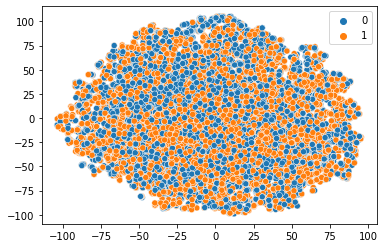

In [59]:
from sklearn.manifold import TSNE
import seaborn as sns

encoded = encoder.predict(X_train)
enc_flat = np.asarray([a.flatten() for a in encoded])
teesnee = TSNE(n_components=2,perplexity=5)
embedded = teesnee.fit_transform(enc_flat)

hue = np.asarray([round(np.mean(a)) for a in y_train])
hue_p = np.asarray([np.mean(a) for a in y_train])

sns.scatterplot(x=embedded[:,0],y=embedded[:,1],hue=hue)

In [61]:
zero_mean = np.mean(enc_flat[hue==0],axis=0)
one_mean = np.mean(enc_flat[hue==1],axis=0)
dis_mat = np.asarray([[np.linalg.norm(a-zero_mean),np.linalg.norm(a-one_mean)] for a in enc_flat])
dis_labs = np.argmin(dis_mat,1)
sum(dis_labs==hue)/len(hue)

0.5248473748473749

In [62]:
enc_val = np.asarray([a.flatten() for a in encoder.predict(X_val)])
hue_val = np.asarray([round(np.mean(a)) for a in y_val])

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10,n_estimators=100)
clf.fit(X=enc_flat,y=hue)
print(clf.score(enc_flat,hue))
print(clf.score(enc_val,hue_val))

0.7035409035409036
0.5947281713344317


In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel="poly",degree=3)
clf.fit(enc_flat,hue)
print(clf.score(enc_flat,hue))
print(clf.score(enc_val,hue_val))

In [64]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=900).fit(enc_flat,hue)
print(clf.score(enc_flat,hue))
print(clf.score(enc_val,hue_val))

0.5675213675213675
0.5744096650192202
